# Logistic Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [65]:
clean_train = "../data/clean/clean_train.csv"
clean_val = "../data/clean/clean_val.csv"
clean_test = "../data/clean/clean_test.csv"
train_subsam = "../data/clean/train_subsam.csv"
train_smote = "../data/clean/train_smote.csv"
log_reg_model = "../models/logreg_model.joblib"

rnd_split = 44
rnd_logreg = 44
rnd_shap = 44

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = "Default"

In [4]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [5]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [6]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Feature Scaling

**Min-Max Scaling**: Algoritmos sensibles a la escala, como k-Nearest Neighbors (k-NN) y redes neuronales con funciones de activación basadas en distancias (como la función sigmoide), pueden beneficiarse de la normalización.

**Z-Score Scaling**: Algunos algoritmos, como la Regresión Logística y el Support Vector Machine (SVM), funcionan mejor con datos estandarizados, ya que asumen una distribución normal.

In [7]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.fit_transform(X_val[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

df_under[num_cols] = scaler.fit_transform(df_under[num_cols])
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

X_train.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA
9598,23,26,0,0,41,5,-0.341220,0.007898,0,1,0,1,0,1,-0.180695,-0.153506,-0.099323,0.806734
309872,31,7,1,4,36,11,0.114695,-0.059885,0,0,1,0,0,0,0.685624,0.725276,0.651788,0.230914
203991,43,47,0,16,45,8,-1.253048,0.428149,0,0,1,0,0,0,0.685624,0.725276,0.913044,1.094644


## Model Training

### Model Tuning

In [8]:
param_grid = {"C": [0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2"],
              "random_state": [rnd_logreg]}

In [ ]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_lr.fit(X_train, y_train)

In [10]:
params = grid_lr.best_params_

print("Better Parameters:", params)

Better Parameters: {'C': 1, 'penalty': 'l2', 'random_state': 44}


In [11]:
lr_model = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=44)

In [31]:
acc_val = lr_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.8556


### Feature Importance

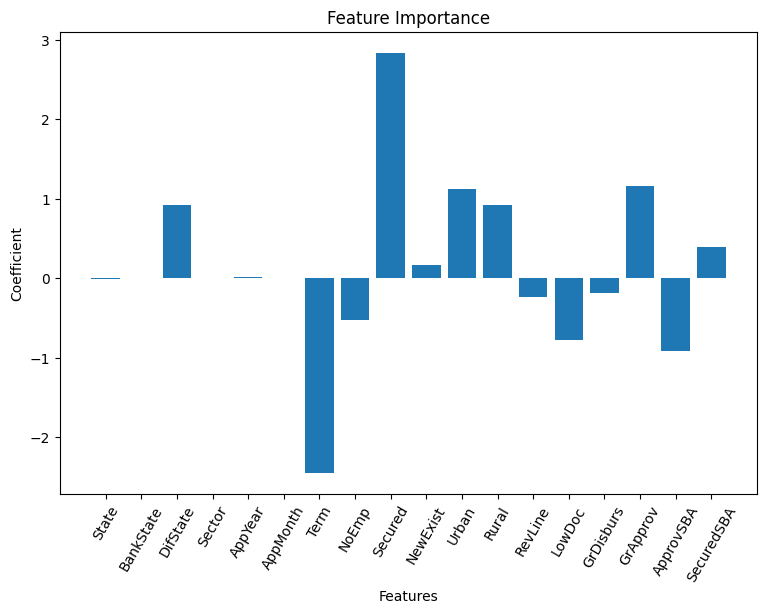

In [13]:
coef_lr = lr_model.coef_[0]
X_cols = X_train.columns

plt.figure(figsize=(9, 6))
plt.bar(X_cols, coef_lr)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [14]:
lr_ref = LogisticRegression(C=params["C"], penalty=params["penalty"],
                            random_state=params["random_state"], max_iter=1000)

In [15]:
rfe_lr = RFE(lr_ref)
rfe_lr.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=1, max_iter=1000, random_state=44))

In [16]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_lr.support_, rfe_lr.ranking_))
rfe_mat

[('State', False, 6),
 ('BankState', False, 8),
 ('DifState', True, 1),
 ('Sector', False, 10),
 ('AppYear', False, 7),
 ('AppMonth', False, 9),
 ('Term', True, 1),
 ('NoEmp', True, 1),
 ('Secured', True, 1),
 ('NewExist', False, 5),
 ('Urban', True, 1),
 ('Rural', True, 1),
 ('RevLine', False, 3),
 ('LowDoc', True, 1),
 ('GrDisburs', False, 4),
 ('GrApprov', True, 1),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', False, 2)]

In [17]:
sel_cols = [tupla[1] for tupla in rfe_mat]
X_train.loc[:, sel_cols].columns

Index(['DifState', 'Term', 'NoEmp', 'Secured', 'Urban', 'Rural', 'LowDoc',
       'GrApprov', 'ApprovSBA'],
      dtype='object')

In [18]:
lr_ref.fit(X_train.loc[:, sel_cols], y_train)

LogisticRegression(C=1, max_iter=1000, random_state=44)

In [32]:
y_ref = lr_ref.predict(X_val.loc[:,sel_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.8479


### Custom Threshold

In [20]:
y_prob = lr_model.predict_proba(X_val)[:, 1]
threshold = 0.4 # p <= 0.4 => 0, p > 0.4 => 1

y_prob = (y_prob >= threshold).astype(int)

In [33]:
acc_ct = accuracy_score(y_val, y_prob)

print("Accuracy CT:", round(acc_ct, 4))

Accuracy CT: 0.861


### Balanced Datasets

**Subsample Dataset**

In [22]:
df_under["Default"].value_counts()

Default
0    109827
1    109827
Name: count, dtype: int64

In [23]:
lr_under = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_under.fit(X_under, y_under)

LogisticRegression(C=1, max_iter=1000, random_state=44)

In [34]:
acc_under = lr_under.score(X_val, y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.1774


**SMOTE Dataset**

In [25]:
df_smote["Default"].value_counts()

Default
0    516843
1    516843
Name: count, dtype: int64

In [26]:
lr_smote = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_smote.fit(X_smote, y_smote)

LogisticRegression(C=1, max_iter=1000, random_state=44)

In [35]:
acc_smote = lr_smote.score(X_val, y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.1771


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [36]:
results = cross_val_score(lr_model, X_test, y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.8532342  0.85561338 0.85531599 0.8533829  0.85256506 0.85152416
 0.85784387 0.85130112 0.8571641  0.85798201]
Accuracy Test (mean +/- desv): 0.8546 +/- 0.0024


In [37]:
y_cv_test = cross_val_predict(lr_model, X_test, y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.8546


**Custom Threshold**

In [38]:
y_prob_cv = cross_val_predict(lr_model, X_test, y_test, cv=10, method="predict_proba")

threshold = 0.4
y_prob_cv = (y_prob_cv[:, 1] >= threshold).astype(int)

In [39]:
acc_cv_ct = accuracy_score(y_test, y_prob_cv)

print("Accuracy CT:", round(acc_cv_ct, 4))

Accuracy CT: 0.8595


**Model Scores**

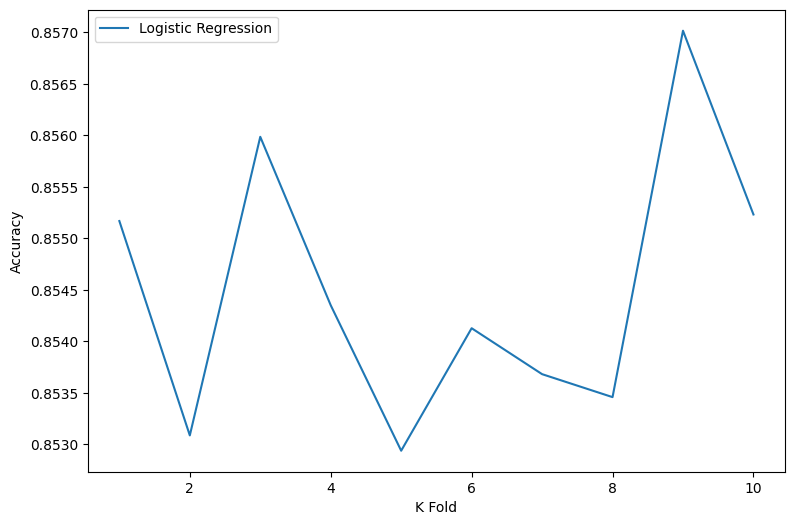

In [41]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(lr_model, X_test, y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Logistic Regression")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
# plt.xlim([1, 10])
# plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [42]:
y_pred = lr_model.predict(X_test)

In [43]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8538
Precisión:    0.7845
Sensibilidad: 0.6388
F1-score:     0.6711


In [44]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8664    0.9721    0.9162    110629
           1     0.7025    0.3055    0.4259     23869

    accuracy                         0.8538    134498
   macro avg     0.7845    0.6388    0.6711    134498
weighted avg     0.8374    0.8538    0.8292    134498



**Confusion Matrix**

In [45]:
cm_lr = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_lr)

[[0.79957323 0.02295945]
 [0.12324347 0.05422385]]


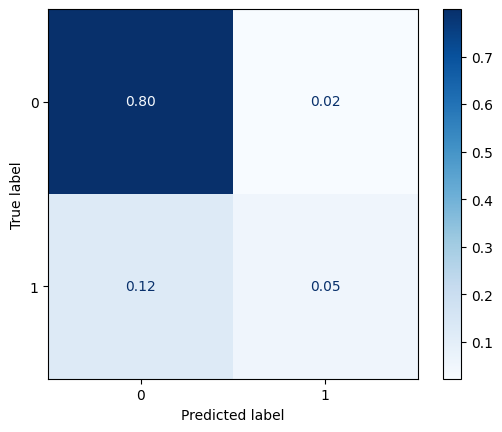

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lr_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

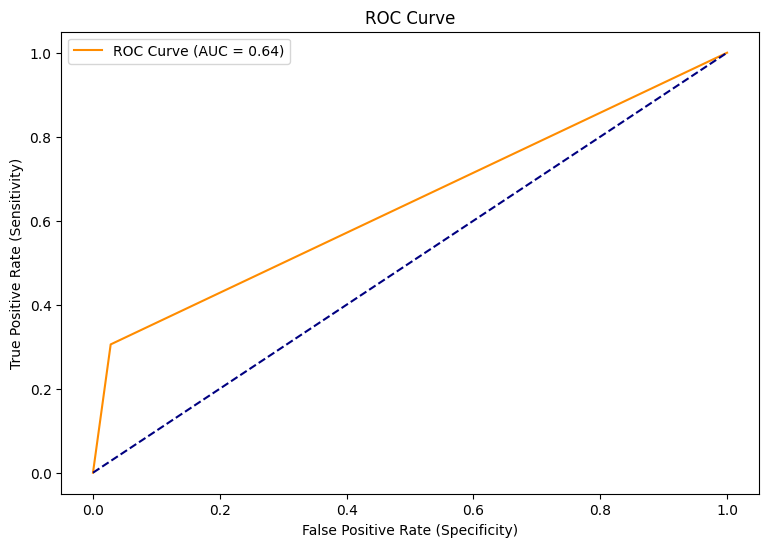

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Interpretability

In [48]:
X_train_sample = X_train.sample(frac=0.0001, random_state=rnd_shap)
X_test_sample = X_test.sample(frac=0.0001, random_state=rnd_shap)

In [49]:
explainer = shap.KernelExplainer(lr_model.predict_proba, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)

100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


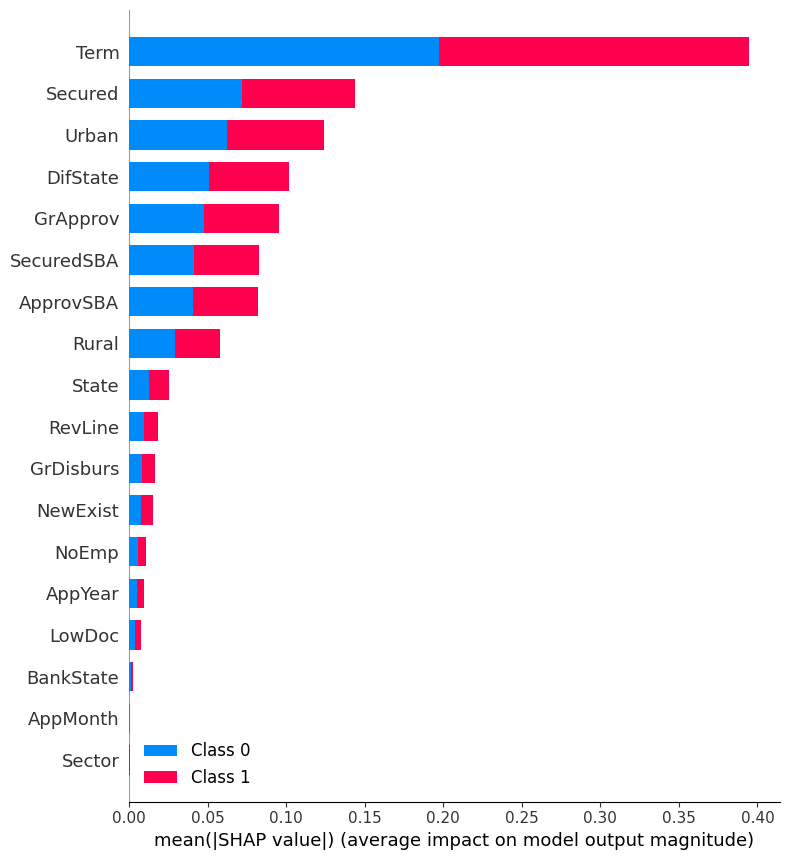

In [50]:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_sample)

In [52]:
row_show = 10
data_pred = X_test_sample.iloc[row_show]
data_pred_array = data_pred.values.reshape(1, -1)

lr_model.predict_proba(data_pred_array)

X does not have valid feature names, but LogisticRegression was fitted with feature names


array([[0.88823848, 0.11176152]])

In [53]:
shap_values = explainer.shap_values(data_pred_array)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_pred_array, feature_names=X_test_sample.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


## Model Pipeline

### Create the Pipeline

In [54]:
class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.encoders = {}

    def fit(self, X, y=None):
        for var in self.variables:
            encoder = StandardScaler()
            encoder.fit(X[var].values.reshape(-1, 1))
            self.encoders[var] = encoder
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for var, encoder in self.encoders.items():
            X[var] = encoder.transform(X[var].values.reshape(-1, 1))
        return X

In [55]:
class LogisticRegressionModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.log_reg = LogisticRegression(C=0.1, penalty="l2",
                                          random_state=rnd_logreg, max_iter=1000)
        self.threshold = 0.4

    def fit(self, X, y):
        self.log_reg.fit(X, y)
        return self

    def transform(self, X):
        return X

    def predict(self, X, y=None):
        y_prob = self.log_reg.predict_proba(X)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        return y_pred

In [56]:
logreg_pipeline = Pipeline([
    ("scaler", ZScoreTransformer(num_cols)),
    ("custom_model", LogisticRegressionModel())
    ])

### Test the Pipeline

**Internal Partition**

In [57]:
logreg_pipeline.fit_transform(X_train, y_train)

y_pred = logreg_pipeline.predict(X_val)

In [58]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.8612
Precisión:    0.7703
Sensibilidad: 0.7094
F1-score:     0.7328


**External Partition**

In [59]:
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

print(f"Train: {X_train.shape} {y_train.shape}")

Train: (761222, 18) (761222,)


In [60]:
logreg_pipeline.fit_transform(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)

In [61]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8611
Precisión:    0.7713
Sensibilidad: 0.7080
F1-score:     0.7320


### Save the Pipeline

In [66]:
joblib.dump(logreg_pipeline, log_reg_model)

logreg_model = joblib.load(log_reg_model)

try:
    logreg_model
    print(f"Logistic Regression is loaded...")

except Exception as err:
    print("Error:", str(err))

Logistic Regression is loaded...


In [67]:
y_pred = logreg_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [68]:
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
70222,23,26,0,2,46,7,-0.490644,-0.110633,0,0,0,1,0,0,-0.577105,-0.557477,-0.502220,1.671503,0,0
73960,4,5,0,13,48,4,-0.338254,0.035073,0,0,1,0,1,0,-0.261004,-0.415059,-0.491160,-1.204085,0,0
9250,45,45,1,12,26,11,-0.262059,-0.070895,0,0,0,0,0,0,-0.263024,-0.237037,-0.159351,1.096385,0,0
127199,14,5,1,0,42,10,2.404774,-0.070895,1,0,1,0,0,0,5.721964,5.869126,5.448229,0.233709,0,0
41260,15,18,0,12,30,4,1.642822,-0.004665,1,0,0,0,0,0,-0.245575,-0.219235,-0.081928,1.671503,0,0
10301,17,9,1,4,41,2,-0.655734,-0.110633,0,0,1,0,1,0,-0.560529,-0.593081,-0.601763,-1.204085,0,0
77770,43,49,1,13,43,2,-1.074808,-0.137124,0,0,1,0,0,0,-0.646901,-0.628686,-0.623884,-1.204085,1,1
128822,4,5,0,20,30,12,2.252384,0.644387,1,0,0,0,0,0,1.154703,1.209394,1.105675,0.233709,0,0
95071,4,49,1,0,43,8,-0.808124,-0.097387,0,0,1,0,0,0,-0.612003,-0.593081,-0.601763,-1.204085,1,1
10531,9,11,0,20,33,10,2.430172,-0.110633,1,0,0,0,0,1,-0.430534,-0.407938,-0.384539,0.521267,0,0
